# Studying the content of the YADL variants

This notebook is used to produce some statistics on the tables stored in YADL and evaluate the main differences between
YADL variants. 

In [1]:
cd ..

/home/soda/rcappuzz/work/benchmark-join-suggestions


In [44]:
import polars as pl
import pandas as pd
import json
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm, NoNorm
norm =  LogNorm()

In [3]:
metadata_dir = Path("data/metadata")

Iterating over all tables in each YADL variant, then saving both the aggregate and complete results in dataframes. 

In [54]:
avg_df = []
all_stats = []
# variants = ["wordnet_cp_fx"]
variants = ["wordnet_big", "wordnet_big_num_cp", "wordnet_cp_fx" ,"wordnet_cp_big_fx"]
for variant in variants:
    print(variant)
    total_files = sum([1 for _ in Path(metadata_dir, variant).glob("**/*.json")])
    # print(f"Total_files: {total_files}")
    if total_files == 0:
        print(f"WARNING: no metadata found for variant {variant} ")
        continue
    mdata_files = Path(metadata_dir, variant).glob("**/*.json")
    total_size = 0
    list_dicts = []
    for f in tqdm(mdata_files, total=total_files):
        with open(f, "r") as fp:
            mdata = json.load(fp)
            table_path = Path(mdata["full_path"])
            file_size = table_path.stat().st_size
            total_size += file_size
            
            table = pl.read_parquet(table_path)
            if table.shape[0] == 1:
                print(f"Skipped tab. {table_path}")
                continue
            subj_avg = table.groupby("subject").count().mean()["count"].item()
            subj_median = table.groupby("subject").count().median()["count"].item()
            cat_feat = 0
            num_feat = 0
            for col, typ in table.schema.items():
                if typ == pl.Utf8:
                    cat_feat += 1
                else:
                    num_feat += 1

            dd = {
                "variant": variant,
                "table_name": table_path.stem,
                "num_rows": table.shape[0],
                "num_cols": table.shape[1],
                "file_size": file_size,
                "subj_avg": subj_avg,
                "subj_median": subj_median,
                "cat_feat": cat_feat,
                "num_feat": num_feat,
            }
            list_dicts.append(dd)
            
    df_stat = pl.from_dicts(list_dicts)
    avg_stats = df_stat.select(
        pl.lit(variant).alias("Variant"),
        pl.col("num_rows").mean().alias("avg_num_rows"),
        pl.col("num_rows").median().alias("median_num_rows"),
        pl.col("num_rows").max().alias("max_num_rows"),
        pl.col("num_rows").min().alias("min_num_rows"),
        pl.col("num_cols").max().alias("max_num_cols"), 
        pl.col("num_cols").min().alias("min_num_cols"), 
        pl.col("file_size").mean().alias("avg_file_size")/1e6,
        pl.col("table_name").count().alias("num_tables"),
        pl.lit(total_size).alias("total_size")/1e6,
        pl.col("subj_avg").mean(),
        pl.col("subj_median").mean(),
        pl.col("cat_feat").mean(),
        pl.col("num_feat").mean(),
    )   
    avg_df.append(avg_stats)
    all_stats.append(df_stat)
all_stat_variants = pl.concat(all_stats)
all_avg_variants = pl.concat(avg_df)

wordnet_big


  0%|          | 0/4080 [00:00<?, ?it/s]

100%|██████████| 4080/4080 [00:35<00:00, 116.34it/s]


wordnet_big_num_cp


100%|██████████| 4062/4062 [00:31<00:00, 130.42it/s]


wordnet_cp_fx


100%|██████████| 1669/1669 [00:38<00:00, 43.86it/s] 


wordnet_cp_big_fx


100%|██████████| 3022/3022 [00:41<00:00, 73.69it/s] 


In [53]:
avg_df

[shape: (1, 14)
 ┌──────────┬────────────┬────────────┬────────────┬───┬──────────┬───────────┬──────────┬──────────┐
 │ Variant  ┆ avg_num_ro ┆ median_num ┆ max_num_ro ┆ … ┆ subj_avg ┆ subj_medi ┆ cat_feat ┆ num_feat │
 │ ---      ┆ ws         ┆ _rows      ┆ ws         ┆   ┆ ---      ┆ an        ┆ ---      ┆ ---      │
 │ str      ┆ ---        ┆ ---        ┆ ---        ┆   ┆ f64      ┆ ---       ┆ f64      ┆ f64      │
 │          ┆ f64        ┆ f64        ┆ i64        ┆   ┆          ┆ f64       ┆          ┆          │
 ╞══════════╪════════════╪════════════╪════════════╪═══╪══════════╪═══════════╪══════════╪══════════╡
 │ wordnet_ ┆ 16031.7384 ┆ 164.0      ┆ 11631285   ┆ … ┆ 16.22432 ┆ 5.095711  ┆ 4.74902  ┆ 0.0      │
 │ big      ┆ 8          ┆            ┆            ┆   ┆          ┆           ┆          ┆          │
 └──────────┴────────────┴────────────┴────────────┴───┴──────────┴───────────┴──────────┴──────────┘,
 shape: (1, 14)
 ┌─────────┬────────────┬────────────┬───────────

Printing the most frequenty types. 

In [7]:
largest_wordnet=all_stat_variants.filter(pl.col("variant")=="wordnet_big").sort("num_rows", descending=True).limit(10).select("table_name").to_series().to_list()
largest_binary=all_stat_variants.filter(pl.col("variant")=="binary").sort("num_rows", descending=True).limit(10).select("table_name").to_series().to_list()

print(f"{'Rank':<10}", f"{'Binary':<40}", 'Wordnet')
for idx in range(10):
    print(f"{idx+1:<10}", f"{largest_binary[idx]:<40}", largest_wordnet[idx])

Rank       Binary                                   Wordnet
1          yago_binary_isCitizenOf                  yagowordnet_wordnet_person
2          yago_binary_hasGender                    person_playsFor_isAffiliatedTo
3          yago_binary_isLocatedIn                  person_wasBornOnDate_playsFor_isAffiliatedTo
4          yago_binary_wasBornOnDate                person_playsFor_isAffiliatedTo_hasHeight
5          yago_binary_isAffiliatedTo               yagowordnet_wordnet_company
6          yago_binary_wasBornIn                    yagowordnet_wordnet_artist
7          yago_binary_playsFor                     person_wasBornOnDate_isAffiliatedTo
8          yago_binary_diedOnDate                   person_wasBornOnDate_playsFor
9          yago_binary_created                      artist_created_wroteMusicFor
10         yago_binary_wasCreatedOnDate             artist_created_hasMusicalRole_wroteMusicFor


Plotting some of the aggregated statistics gathered in the previous step. 

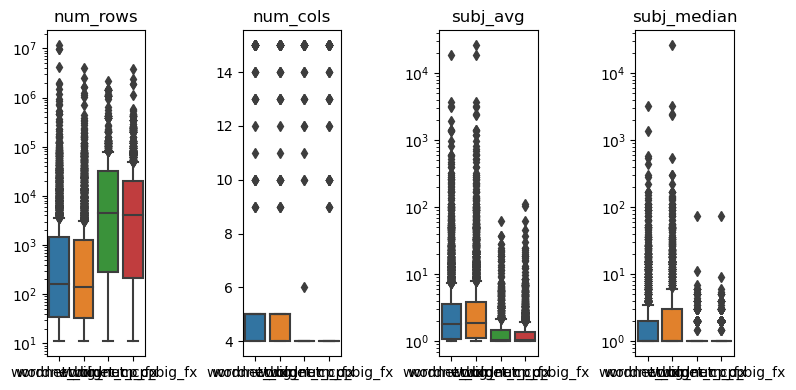

In [46]:
variables_of_interest = ["num_rows", "num_cols", "subj_avg", "subj_median"]
df_melt=all_stat_variants.melt(
    id_vars=["variant"],
    value_vars=variables_of_interest
)

fig, axs = plt.subplots(1, len(variables_of_interest), figsize=(8,4))
for idx, var in enumerate(variables_of_interest):
    ax = axs[idx]
    ax=sns.boxplot(data=df_melt.filter(pl.col("variable")==var).to_pandas(), x="variant", y="value", ax=ax)
    if var != "num_cols":
        ax.set_yscale("log")
    ax.set_title(var)
    ax.set_xlabel("")
    ax.set_ylabel("")
    
    # ax.get_legend().remove()

plt.tight_layout() 

<Axes: xlabel='cat_feat', ylabel='num_feat'>

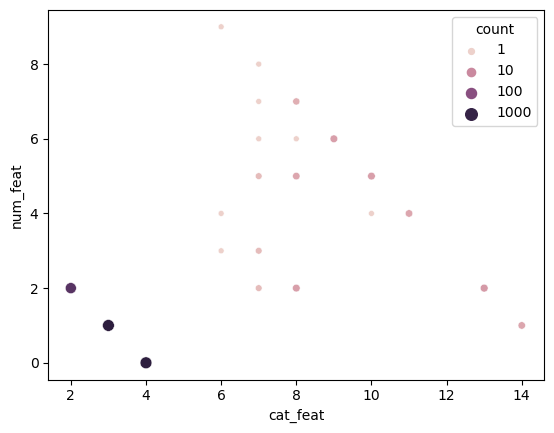

In [47]:
sns.scatterplot(data=df_stat.groupby(["cat_feat", "num_feat"]).agg(pl.count()),x="cat_feat", y="num_feat", size="count", hue="count", size_norm=norm, hue_norm=norm)

Preparing the aggregated stats

# Base table stats

In [ ]:
data_dir = Path("data/metadata/queries")
tabs_mdata_paths = list(data_dir.glob("*.json"))

In [ ]:
stats_list = []
for tab_mdata_pth in tabs_mdata_paths:
    with open(tab_mdata_pth, "r") as fp:
        tab_mdata = json.load(fp)
        tab_path = tab_mdata["full_path"]
        tab = pl.read_parquet(tab_path).unique()
        cat_feat = 0
        num_feat = 0
        for col, typ in tab.schema.items():
            if typ == pl.Utf8:
                cat_feat += 1
            else:
                num_feat += 1
        stats = {
            "tab_name": tab_mdata["df_name"],
            # "tab_source": "add",
            "num_rows": tab.shape[0],
            # "num_cols": tab.shape[1],
            "cat_feat": cat_feat,
            "num_feat": num_feat,
            # "target": "add"
        }
        stats_list.append(stats)

In [ ]:
base_table_stats = pl.from_dicts(stats_list)
base_table_stats = base_table_stats.select(
    pl.col("tab_name").alias("Table name"),
    pl.col("num_rows").alias("Rows"),
    pl.col("cat_feat").alias("$C$"),
    pl.col("num_feat").alias("$N$"),
)

In [ ]:
base_table_stats.to_pandas().style.to_latex("base_tables.tex", hrules=True)

In [ ]:
base_table_stats

Table name,Rows,$C$,$N$
str,i64,i64,i64
"""presidential-r…",22084,12,1
"""company-employ…",3107,8,2
"""movies-prepare…",3826,14,5
"""us-accidents-p…",20000,23,28
"""us-accidents-p…",5222,10,3
"""presidential-r…",21289,6,1
